# Building the EchoScope Model - 2

In [1]:
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
IQ_Processed = np.load('../data/processed_iq_data.npz')
Spectrogram_Processed = np.load('../data/spectrograms.npz')

In [4]:
X_list = []
y_list = []

for key_str in IQ_Processed.files:
    key = ast.literal_eval(key_str)
    mod_name = key[0]
    data = IQ_Processed[key_str]
    
    X_list.append(data)
    y_list.extend([mod_name] * data.shape[0])

X = np.vstack(X_list)
y = np.array(y_list)

print(f'Total samples: {X.shape[0]}')
print(f'Unique modulations: {np.unique(y)}')
unique_modulations = np.unique(y)

Total samples: 220000
Unique modulations: ['8PSK' 'AM-DSB' 'AM-SSB' 'BPSK' 'CPFSK' 'GFSK' 'PAM4' 'QAM16' 'QAM64'
 'QPSK' 'WBFM']


In [5]:
def split_sets(X, y):
    X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)
    
    print(f'Train shape: {X_train.shape}, {y_train.shape}')
    print(f'Validation shape: {X_val.shape}, {y_val.shape}')
    print(f'Test shape: {X_test.shape}, {y_test.shape}')
    return X_train, y_train, X_val, y_val, X_test, y_test

In [6]:
X_train, y_train, X_val, y_val, X_test, y_test = split_sets(X, y)

Train shape: (132000, 2, 128), (132000,)
Validation shape: (44000, 2, 128), (44000,)
Test shape: (44000, 2, 128), (44000,)


In [7]:
LE = LabelEncoder()
y_train_enc = LE.fit_transform(y_train)
y_val_enc = LE.transform(y_val)
y_test_enc = LE.transform(y_test)

print(LE.classes_)

['8PSK' 'AM-DSB' 'AM-SSB' 'BPSK' 'CPFSK' 'GFSK' 'PAM4' 'QAM16' 'QAM64'
 'QPSK' 'WBFM']


In [8]:
train_dataset_time = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train_enc, dtype=torch.long))
val_dataset_time = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val_enc, dtype=torch.long))
test_dataset_time = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test_enc, dtype=torch.long))

train_loader_time = DataLoader(train_dataset_time, batch_size=64, shuffle=True)
val_loader_time = DataLoader(val_dataset_time, batch_size=64, shuffle=False)
test_loader_time = DataLoader(test_dataset_time, batch_size=64, shuffle=False)

In [9]:
class Time_Series_Model(nn.Module):
    def __init__(self, input_size=128, hidden_size=32, output_size=11, num_layers=1, dropout=0.5):
        super(Time_Series_Model, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=False,
            dropout=0.0  
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_out = lstm_out[:, -1, :]
        out = self.dropout(last_out)
        out = self.fc(out)
        return out

In [10]:
Time_Series_Model_V1 = Time_Series_Model()
Time_Series_Model_V1 = Time_Series_Model_V1.to(device)

In [11]:
def set_seed(seed=1):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

In [12]:
import copy

def train_model(model, criterion, optimizer, epochs, train_loader, val_loader, patience=5, scheduler=None):
    best_val_loss = float('inf')
    best_model_state = None
    no_improve_epochs = 0
    
    train_losses = []
    val_losses = []

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)
        val_loss /= len(val_loader.dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print(f"Early stopping at epoch {epoch} (best val loss: {best_val_loss:.6f})")
                break
        if scheduler:
            scheduler.step(val_loss)
            
    model.load_state_dict(best_model_state)
    return train_losses, val_losses


In [13]:
optimizer = optim.Adam(Time_Series_Model_V1.parameters(), lr=0.0001)
train_losses, val_losses = train_model(model=Time_Series_Model_V1, criterion=nn.CrossEntropyLoss(), 
            optimizer=optimizer, epochs=50, train_loader=train_loader_time, 
            val_loader=val_loader_time)

Epoch 1/50 | Train Loss: 2.389943 | Val Loss: 2.359640
Epoch 2/50 | Train Loss: 2.328111 | Val Loss: 2.275002
Epoch 3/50 | Train Loss: 2.243150 | Val Loss: 2.184887
Epoch 4/50 | Train Loss: 2.177894 | Val Loss: 2.126965
Epoch 5/50 | Train Loss: 2.137471 | Val Loss: 2.094053
Epoch 6/50 | Train Loss: 2.115498 | Val Loss: 2.073941
Epoch 7/50 | Train Loss: 2.097974 | Val Loss: 2.060614
Epoch 8/50 | Train Loss: 2.087608 | Val Loss: 2.051664
Epoch 9/50 | Train Loss: 2.076980 | Val Loss: 2.044334
Epoch 10/50 | Train Loss: 2.068979 | Val Loss: 2.038753
Epoch 11/50 | Train Loss: 2.061037 | Val Loss: 2.034074
Epoch 12/50 | Train Loss: 2.058266 | Val Loss: 2.030413
Epoch 13/50 | Train Loss: 2.052641 | Val Loss: 2.026873
Epoch 14/50 | Train Loss: 2.048090 | Val Loss: 2.024007
Epoch 15/50 | Train Loss: 2.044190 | Val Loss: 2.021280
Epoch 16/50 | Train Loss: 2.040208 | Val Loss: 2.018549
Epoch 17/50 | Train Loss: 2.035512 | Val Loss: 2.016043
Epoch 18/50 | Train Loss: 2.031967 | Val Loss: 2.014130
E

### Hyperparameter Trials: 

#### Trial 1: Complex model w/o dropout
The model overfitted with the following hyperparameters: input_size=128, hidden_size=64, output_size=11, num_layers=1, dropout=0, learning_rate=0.0001, optimizer=Adam, loss_fn=CrossEntropyLoss, epochs=50, using a bidirectional LSTM without effective dropout due to num_layers=1.

#### Trial 2: Complex model w/ dropout
The model previously overfitted using the following configuration: input_size=128, hidden_size=64, output_size=11, num_layers=2, dropout=0.5, bidirectional=True, learning_rate=0.0001, optimizer=Adam, and CrossEntropyLoss. Despite enabling both internal and external dropout, validation loss steadily increased while training loss decreased, indicating the model capacity was too high for the dataset. This prompted a simplification of the architecture to reduce overfitting risk.

#### Trial 3: Simplified model w/dropout
The simplified model (input_size=128, hidden_size=32, output_size=11, num_layers=1, dropout=0.5, bidirectional=False, learning_rate=0.0001) showed significantly improved generalization compared to the previous overfitted configuration. Both training and validation loss decreased steadily over 50 epochs, confirming that reducing model complexity effectively mitigated overfitting and led to stable convergence.

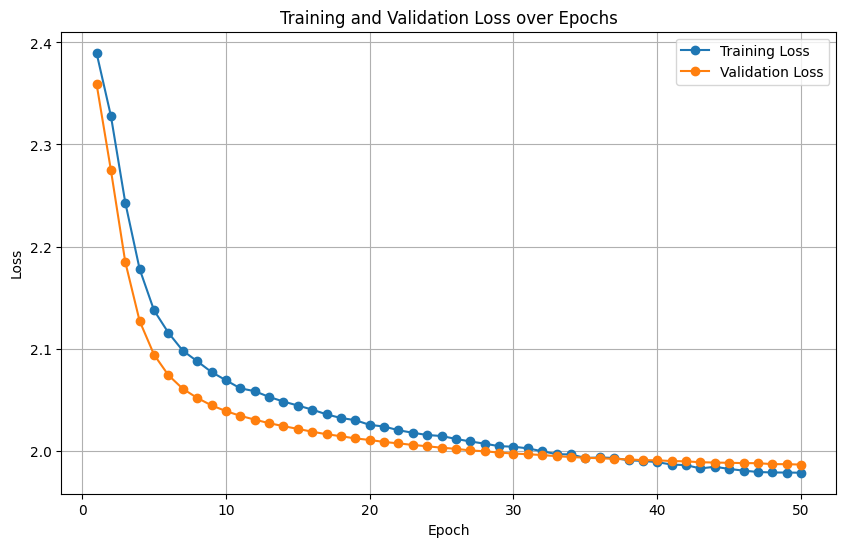

In [14]:
epochs = range(1, 51)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
keys = Spectrogram_Processed.files
print(keys)

key_example = "('QPSK', 2)"
if key_example in keys:
    data = Spectrogram_Processed[key_example]
    print(f"Data shape for {key_example}:", data.shape)
else:
    print(f"{key_example} not found in the file.")

["('QPSK', 2)", "('PAM4', 8)", "('AM-DSB', -4)", "('GFSK', 6)", "('QAM64', 8)", "('AM-SSB', 12)", "('8PSK', 8)", "('8PSK', 12)", "('QAM64', -6)", "('QAM16', 2)", "('QAM16', -20)", "('PAM4', -6)", "('WBFM', -18)", "('AM-DSB', 16)", "('CPFSK', 10)", "('WBFM', 6)", "('BPSK', 4)", "('BPSK', -2)", "('QPSK', -20)", "('CPFSK', -8)", "('AM-SSB', 6)", "('QAM64', -20)", "('QAM16', 12)", "('GFSK', -20)", "('AM-SSB', -12)", "('CPFSK', 0)", "('AM-DSB', 6)", "('BPSK', -16)", "('QPSK', -6)", "('8PSK', -12)", "('CPFSK', -18)", "('BPSK', -10)", "('QPSK', 8)", "('PAM4', 14)", "('AM-DSB', -10)", "('GFSK', 12)", "('QAM64', 2)", "('WBFM', -4)", "('AM-SSB', -18)", "('QAM64', -4)", "('GFSK', -4)", "('AM-DSB', 8)", "('PAM4', -16)", "('QPSK', -16)", "('BPSK', 16)", "('8PSK', -8)", "('CPFSK', 16)", "('WBFM', 0)", "('QPSK', 6)", "('BPSK', 14)", "('AM-DSB', -8)", "('GFSK', -10)", "('CPFSK', -2)", "('AM-SSB', 8)", "('GFSK', 18)", "('QAM16', 6)", "('QAM16', -16)", "('QAM64', 18)", "('AM-SSB', -2)", "('CPFSK', 6)", 

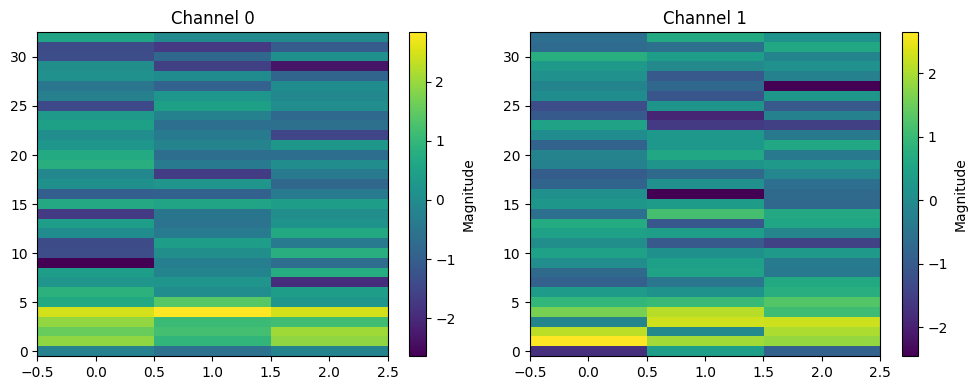

In [14]:
example = data[0] 
plt.figure(figsize=(10,4))
for ch in range(example.shape[0]):
    plt.subplot(1, 2, ch+1)
    plt.title(f'Channel {ch}')
    plt.imshow(example[ch], aspect='auto', origin='lower')
    plt.colorbar(label='Magnitude')
plt.tight_layout()
plt.show()

In [15]:
all_data_spect = []
all_labels_spect = []
keys_tuples = [eval(k) if isinstance(k, str) else k for k in Spectrogram_Processed.keys()]
label_map = {mod: i for i, mod in enumerate(unique_modulations)}

for key in keys_tuples:
    modulation = key[0]
    str_key = str(key)
    data = Spectrogram_Processed[str_key]
    all_data_spect.append(data)
    
    labels = np.full(data.shape[0], label_map[modulation])
    all_labels_spect.append(labels)

X = np.concatenate(all_data_spect, axis=0)
y = np.concatenate(all_labels_spect, axis=0)

print(f"Combined data shape: {X.shape}")
print(f"Combined labels shape: {y.shape}")
print(f"Label map: {label_map}")


Combined data shape: (220000, 2, 33, 3)
Combined labels shape: (220000,)
Label map: {np.str_('8PSK'): 0, np.str_('AM-DSB'): 1, np.str_('AM-SSB'): 2, np.str_('BPSK'): 3, np.str_('CPFSK'): 4, np.str_('GFSK'): 5, np.str_('PAM4'): 6, np.str_('QAM16'): 7, np.str_('QAM64'): 8, np.str_('QPSK'): 9, np.str_('WBFM'): 10}


In [16]:
X_train, y_train, X_val, y_val, X_test, y_test = split_sets(X, y)

Train shape: (132000, 2, 33, 3), (132000,)
Validation shape: (44000, 2, 33, 3), (44000,)
Test shape: (44000, 2, 33, 3), (44000,)


In [17]:
LE = LabelEncoder()
y_train_enc = LE.fit_transform(y_train)
y_val_enc = LE.transform(y_val)
y_test_enc = LE.transform(y_test)

print(LE.classes_)

[ 0  1  2  3  4  5  6  7  8  9 10]


In [18]:
train_dataset_spect = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train_enc, dtype=torch.long))
val_dataset_spect = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val_enc, dtype=torch.long))
test_dataset_spect = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test_enc, dtype=torch.long))

train_loader_spect = DataLoader(train_dataset_spect, batch_size=64, shuffle=True)
val_loader_spect = DataLoader(val_dataset_spect, batch_size=64, shuffle=False)
test_loader_spect = DataLoader(test_dataset_spect, batch_size=64, shuffle=False)

In [27]:
class SpectrogramPatchEncoder(nn.Module):
    def __init__(self, in_channels=2, patch_size=(1, 1), embed_dim=128, img_size=(33, 3)):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim

        self.num_patches = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])

        self.proj = nn.Conv2d(
            in_channels,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )
        
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches + 1, embed_dim))

    def forward(self, x):
        B = x.size(0)
        x = self.proj(x) 
        x = x.flatten(2).transpose(1, 2)

        cls_tokens = self.cls_token.expand(B, -1, -1)

        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed

        return x

In [28]:
class SpectrogramModel(nn.Module):
    def __init__(self, in_channels=2, img_size=(33, 3), patch_size=(1, 1), embed_dim=128, num_classes=11):
        super().__init__()
        self.patch_encoder = SpectrogramPatchEncoder(
            in_channels=in_channels,
            patch_size=patch_size,
            embed_dim=embed_dim,
            img_size=img_size
        )
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=8, dim_feedforward=256, batch_first=True),
            num_layers=4
        )
        self.classifier = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Dropout(0.3),
            nn.Linear(embed_dim, num_classes)
        )
    def forward(self, x):
        x = self.patch_encoder(x)
        x = self.transformer(x)
        x = x[:, 0]
        x = self.classifier(x)
        return x
        

In [29]:
Spectrogram_Model_V1 = SpectrogramModel(in_channels=2, img_size=(33, 3), patch_size=(1, 1), embed_dim=256,
                                                 num_classes=11).to(device)

In [30]:
optimizer = optim.Adam(Spectrogram_Model_V1.parameters(), lr=0.0001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
train_losses_spect, val_losses_spect = train_model(model=Spectrogram_Model_V1, criterion=nn.CrossEntropyLoss(), 
            optimizer=optimizer, epochs=50, train_loader=train_loader_spect, 
            val_loader=val_loader_spect, scheduler=scheduler)

Epoch 1/50 | Train Loss: 1.894890 | Val Loss: 1.691245
Epoch 2/50 | Train Loss: 1.695289 | Val Loss: 1.663468
Epoch 3/50 | Train Loss: 1.665846 | Val Loss: 1.659609
Epoch 4/50 | Train Loss: 1.649882 | Val Loss: 1.635799
Epoch 5/50 | Train Loss: 1.640233 | Val Loss: 1.637223
Epoch 6/50 | Train Loss: 1.632571 | Val Loss: 1.628420
Epoch 7/50 | Train Loss: 1.627160 | Val Loss: 1.635644
Epoch 8/50 | Train Loss: 1.622264 | Val Loss: 1.624057
Epoch 9/50 | Train Loss: 1.618722 | Val Loss: 1.633747
Epoch 10/50 | Train Loss: 1.615379 | Val Loss: 1.617612
Epoch 11/50 | Train Loss: 1.612454 | Val Loss: 1.623166
Epoch 12/50 | Train Loss: 1.609125 | Val Loss: 1.611713
Epoch 13/50 | Train Loss: 1.607291 | Val Loss: 1.618092
Epoch 14/50 | Train Loss: 1.605280 | Val Loss: 1.614538
Epoch 15/50 | Train Loss: 1.604086 | Val Loss: 1.608621
Epoch 16/50 | Train Loss: 1.601205 | Val Loss: 1.614283
Epoch 17/50 | Train Loss: 1.600509 | Val Loss: 1.621700
Epoch 18/50 | Train Loss: 1.598327 | Val Loss: 1.614858
E

KeyboardInterrupt: 

In [23]:
Spectrogram_Model_V1.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader_spect:
        X_batch = X_batch.to(device)
        outputs = Spectrogram_Model_V1(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(y_batch.numpy())

print(classification_report(y_true, y_pred, target_names=[str(c) for c in LE.classes_]))

              precision    recall  f1-score   support

           0       0.19      0.10      0.13      4000
           1       0.19      0.14      0.16      4000
           2       0.21      0.79      0.33      4000
           3       0.48      0.24      0.32      4000
           4       0.69      0.59      0.63      4000
           5       0.67      0.59      0.63      4000
           6       0.57      0.55      0.56      4000
           7       0.25      0.33      0.28      4000
           8       0.36      0.37      0.36      4000
           9       0.17      0.02      0.03      4000
          10       0.55      0.19      0.28      4000

    accuracy                           0.36     44000
   macro avg       0.39      0.36      0.34     44000
weighted avg       0.39      0.36      0.34     44000



The spectrogram transformer model was trained with patch_size=(3, 3), embed_dim=128, 4 transformer layers, and 8 attention heads using the Adam optimizer (lr=1e-4) over a maximum of 50 epochs with early stopping (patience=5).
The best validation loss achieved was 1.6093, occurring at Epoch 12, after which performance plateaued and slightly degraded, indicating early signs of overfitting. This model achieved an accuracy of 39%. 

With in_channels=2, patch size (1, 1), and an embedding dimension of 256, the Spectrogram Transformer model trained over 50 epochs achieved a plateau in validation loss around epoch 20, indicating the need for architectural or regularization improvements to further enhance generalization.